<a href="https://colab.research.google.com/github/9zxu/data-analysis/blob/main/spotify_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

- [dataset link](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset)

## Summary of Features
The features that are most suitable for a music recommendation system include both low-level features (often used for research into acoustic similarity) and high-level descriptors:
- High-Level Descriptors: Genre, mood (e.g., happy, sad, relaxed), energy, danceability, and popularity.
- Low-Level Audio Features: Tempo (BPM), key, loudness, acousticness, instrumentalness, valence, Mel-frequency cepstral coefficients (MFCCs), and chroma features.


## import and prepare dataset

In [1]:
import pandas as pd
import numpy as np
import kagglehub

import torch
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

spotigreen = "#2ecc71"

print("Downloading dataset...")
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
df = pd.read_csv(path + '/dataset.csv')

Using Colab cache for faster access to the '-spotify-tracks-dataset' dataset.


## Data cleaning

### missing value


In [2]:
del_row = df[df.isnull().any(axis=1)]
display(del_row.head())
df = df.drop(del_row.index)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,...,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


In [3]:
print(f"Data Loaded: {df.shape[0]} tracks.")

Data Loaded: 113999 tracks.


## Dulplicates

- `track_genre` is seperated among different row entries


In [4]:
df[df['track_id'] == '5SuOikwiRyPMVoIQDJUgSV']

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
62102,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917,4,j-pop
99152,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917,4,singer-songwriter
102151,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917,4,songwriter


analyze destribution before merging genre
- `track_genre` is quite evenly distrubuted.

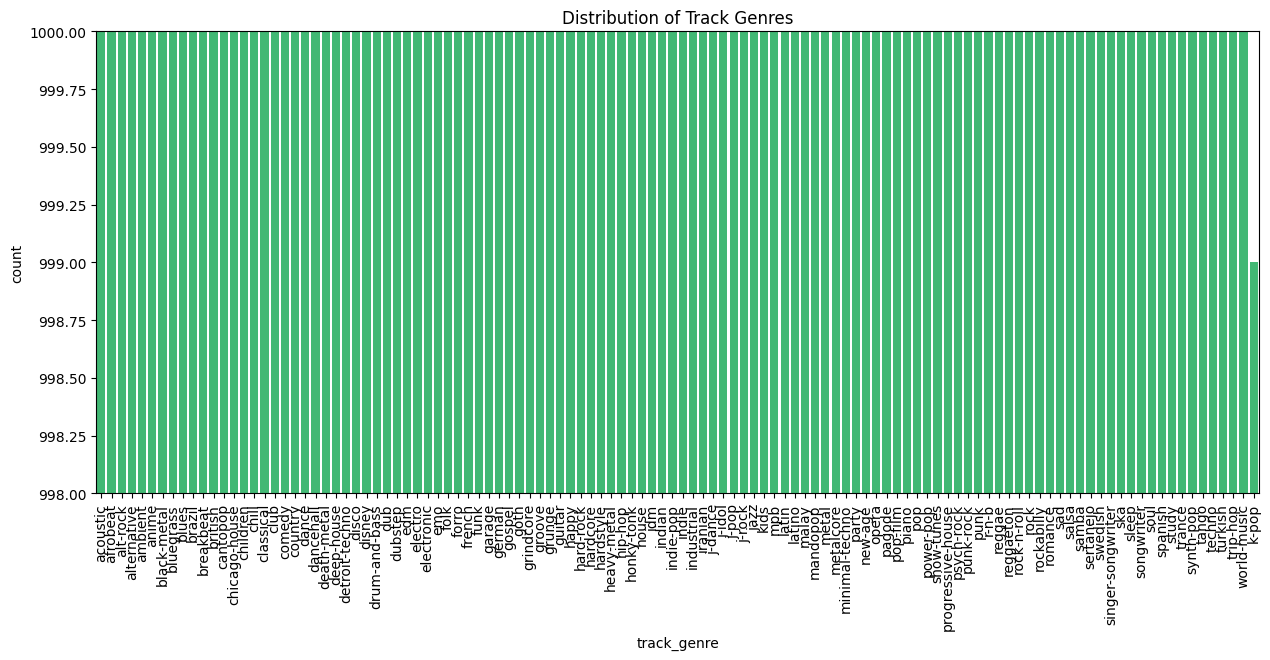

In [5]:
plt.figure(figsize=(15, 6))
sns.countplot(x=df['track_genre'], order=df['track_genre'].value_counts().index, color=spotigreen)
plt.title('Distribution of Track Genres')
plt.ylim(998, 1000)
plt.xticks(rotation=90)
plt.show()

The duplicated columns should be merged befor analyzing the distrubution of other features.

- Group by the unique track identifiers

In [6]:
df['track_genre'] = df.groupby('track_id')['track_genre'].transform(lambda x: ';'.join(x.unique()))
df = df.drop_duplicates(subset=['track_id'])

In [7]:
df[df['track_id'] == '5SuOikwiRyPMVoIQDJUgSV']

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917,4,acoustic;j-pop;singer-songwriter;songwriter


In [8]:
print(f"Data Loaded: {df.shape[0]} tracks.")

Data Loaded: 89740 tracks.


## distribution

# EDA

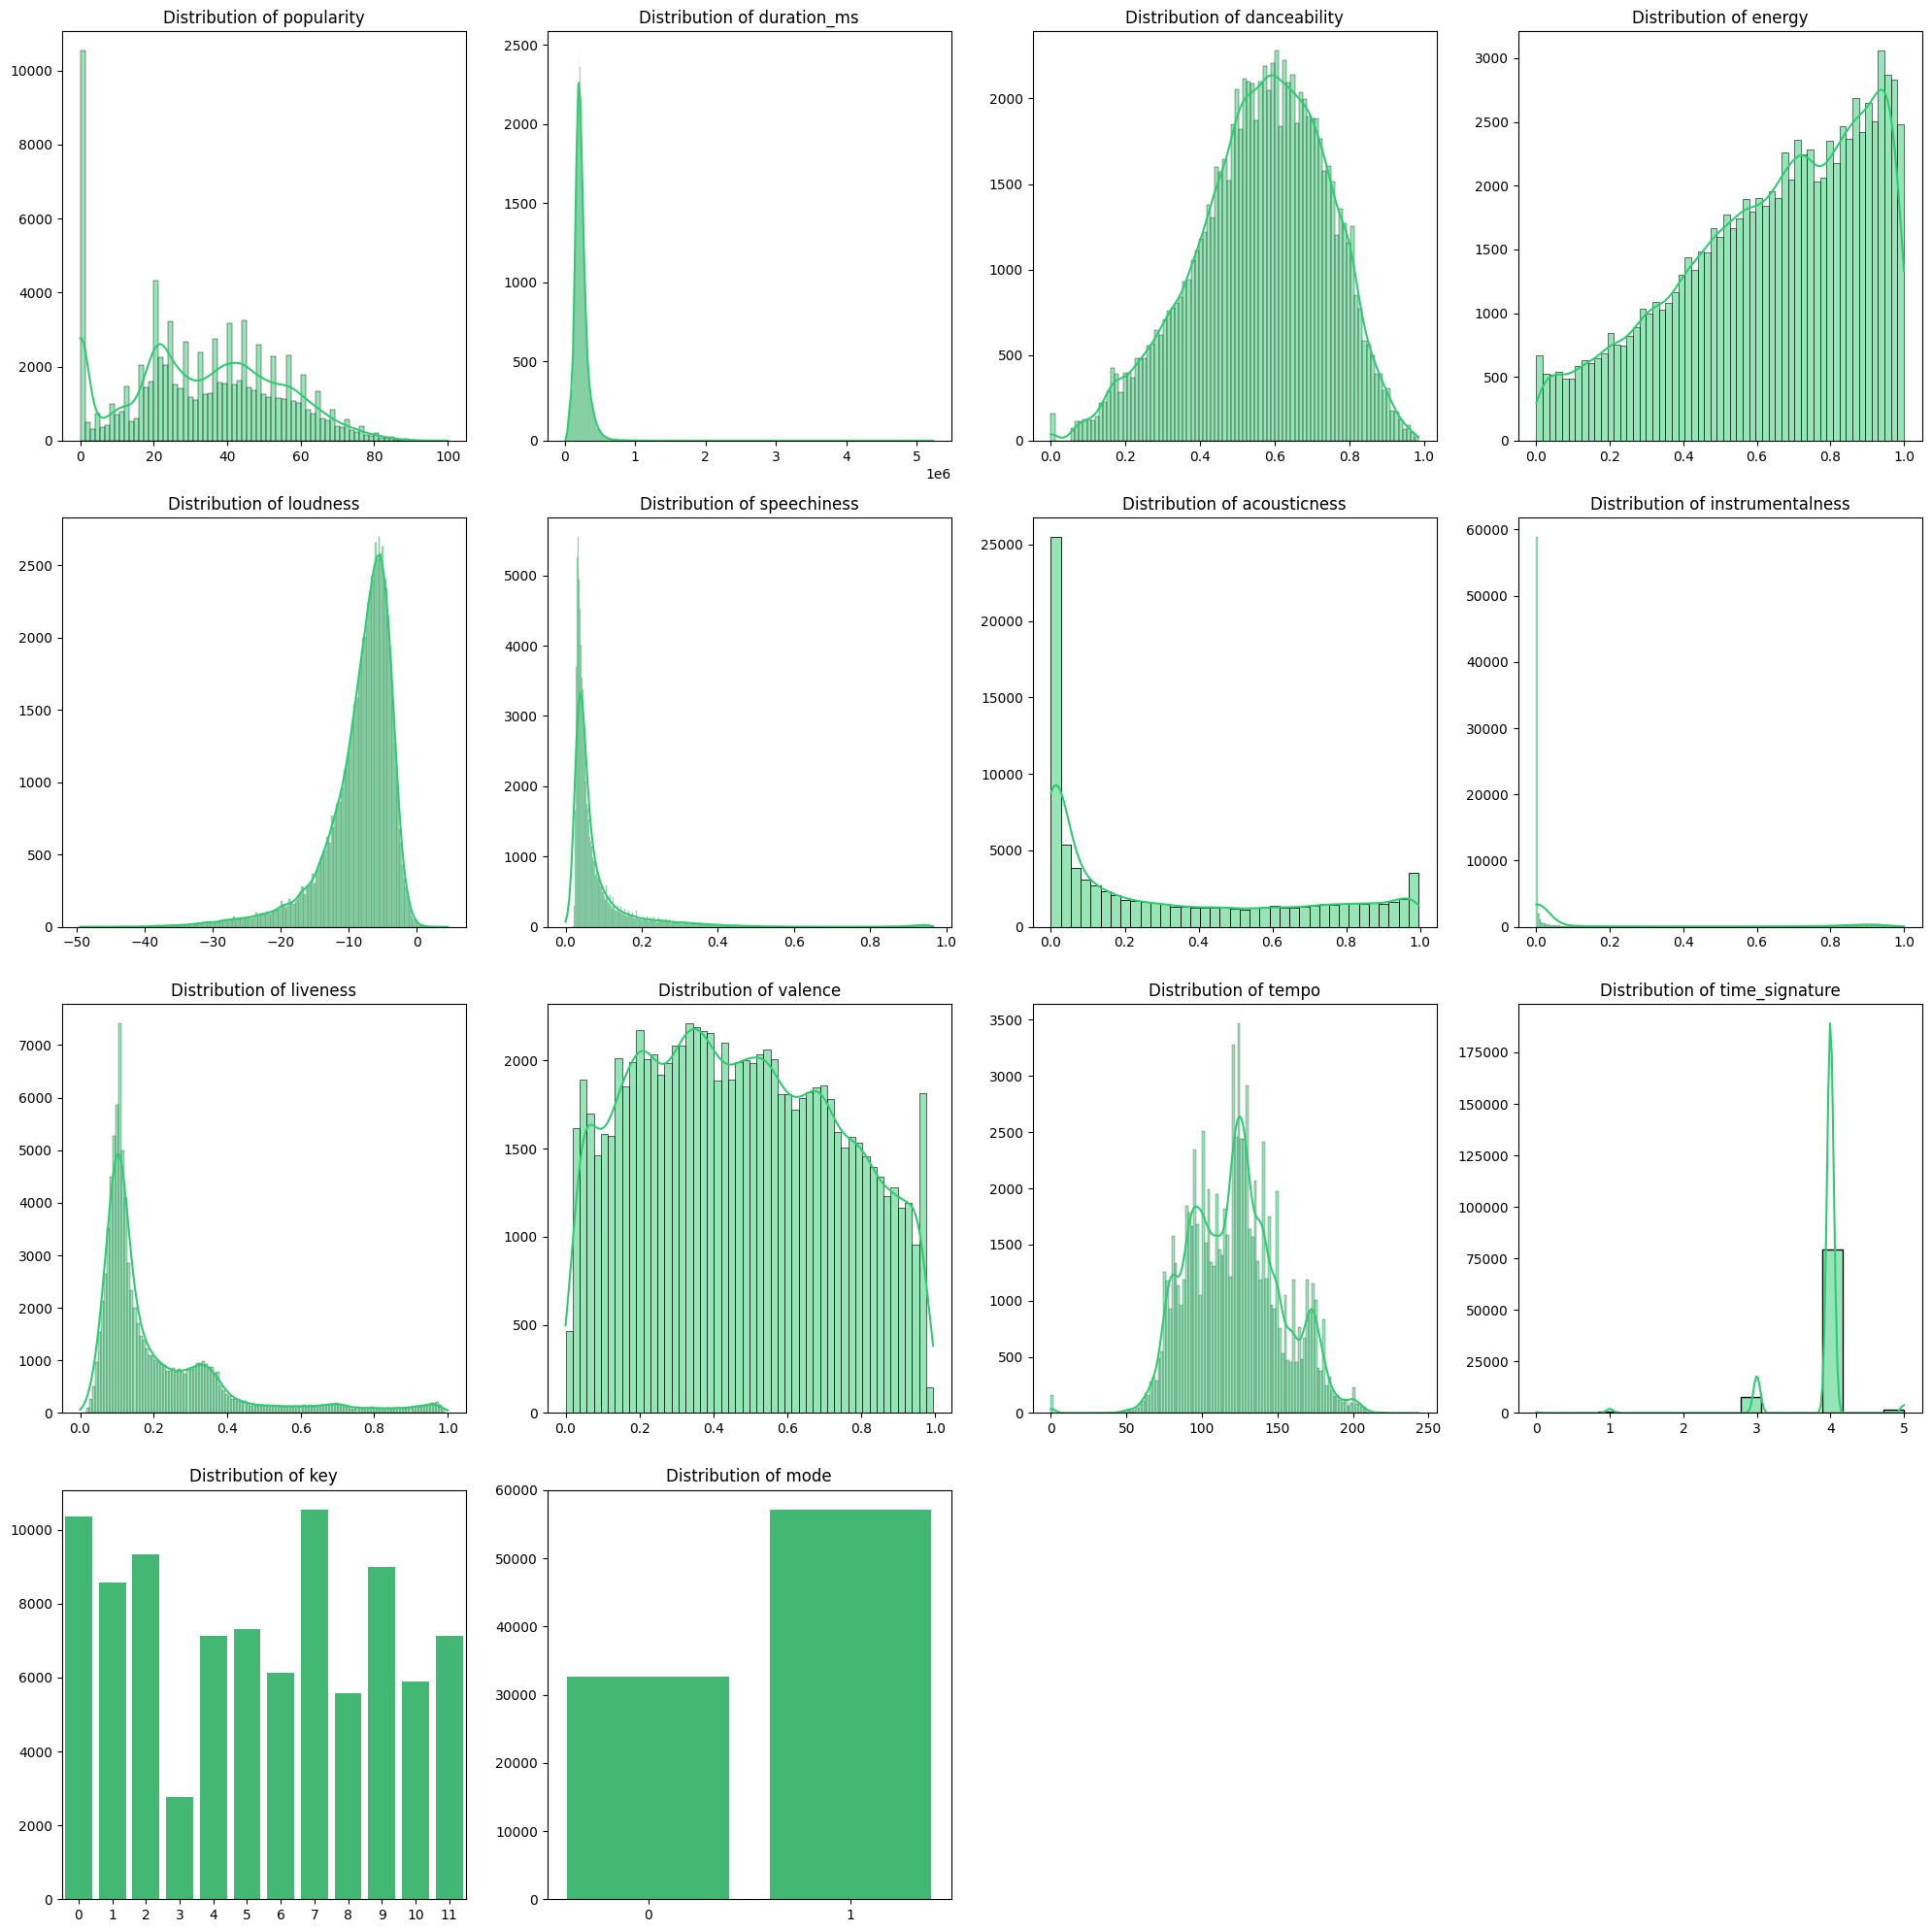

In [9]:
numerical_cols = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'key', 'mode']

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    if col in ['key', 'mode']:
        sns.countplot(x=df[col], ax=axes[i], color=spotigreen)
    else:
        sns.histplot(df[col], kde=True, ax=axes[i], color=spotigreen)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
print('Explicit distribution in Percentage')
for row in df['explicit'].value_counts().items():
    print(row[0],":", row[1] / len(df) * 100 , "%")

Explicit distribution in Percentage
False : 91.41519946512146 %
True : 8.584800534878537 %


## top 10 artists
by count and popularity in this dataset

plt draw by dict

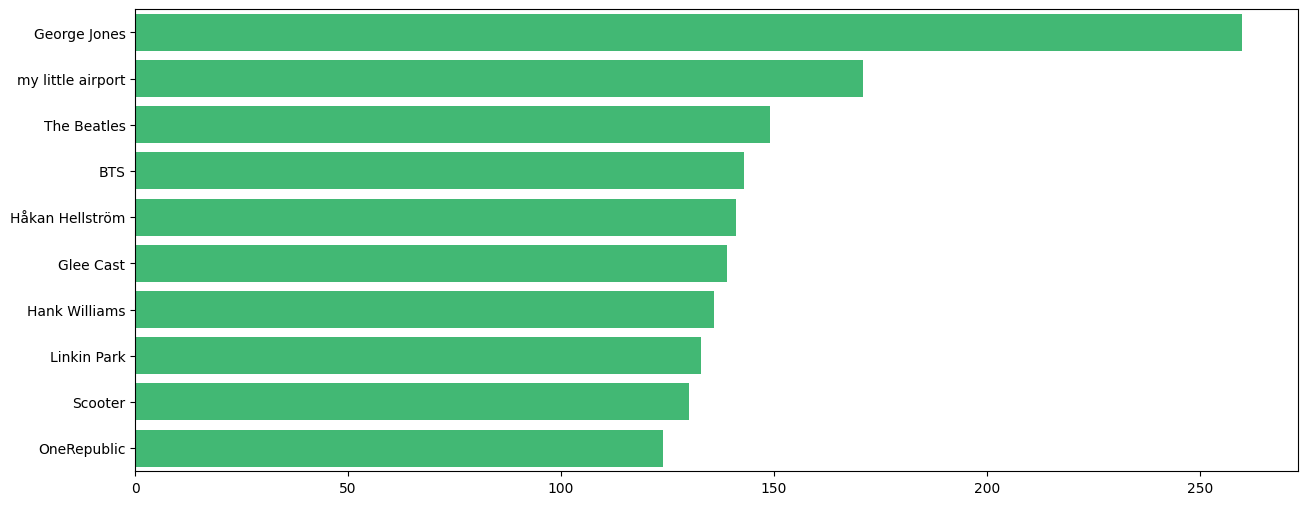

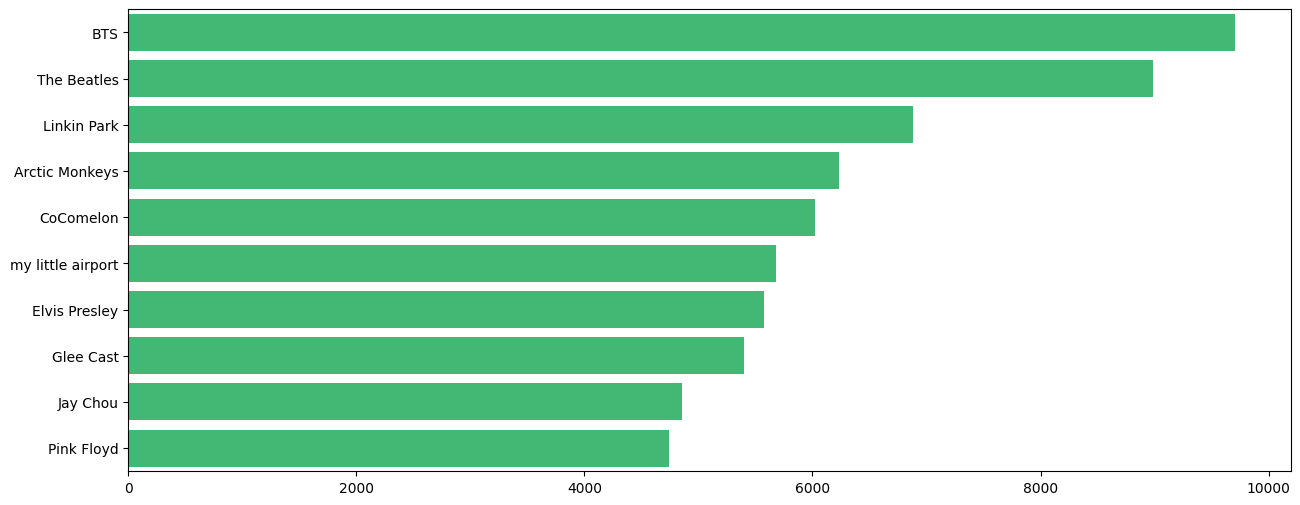

In [11]:
def plot_dict(d):
    d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
    labels = list(d.keys())[:10]
    values = list(d.values())[:10]
    plt.figure(figsize=(15, 6))
    sns.barplot(x=values, y=labels, color=spotigreen)
    plt.show()

def by_artisit(df):
    artist_count = {}
    artist_pop_count = {}
    cols = ['artists', 'popularity']
    df_selecetd = df[cols]
    for row in df_selecetd.itertuples():
        name_list = row.artists
        for name in name_list.split(','):
            if name in artist_count:
                artist_count[name] += 1
                artist_pop_count[name] += row.popularity
            else:
                artist_count[name] = 1
                artist_pop_count[name] = row.popularity

    plot_dict(artist_count)
    plot_dict(artist_pop_count)

by_artisit(df)

# Feature Engineering

In [12]:
numerical_cols = ['popularity', 'duration_ms', 'danceability', 'energy',
                  'loudness', 'speechiness', 'acousticness', 'instrumentalness',
                  'liveness', 'valence', 'tempo']

- normalize numerical data

- The `MinMaxScaler` transforms features by scaling each feature to a given range, typically between 0 and 1.

$$
X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$

In [13]:
scaler = MinMaxScaler()
audio_features = scaler.fit_transform(df[numerical_cols])

- rich text representation (combining Track, Artist, and Genre) captures deeper semantic relationships and contextual nuances between metadata fields while simplifying the search pipeline and reducing storage overhead compared to managing separate embeddings.

- `astype` transfer the original data to the specified `dtype`

In [14]:
df['text_soup'] = (
    "Track: " + df['track_name'].astype(str) +
    " - Artist: " + df['artists'].astype(str) +
    " - Genre: " + df['track_genre'].astype(str)
)

In [15]:
print("Generating Text Embeddings")
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')

Generating Text Embeddings


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


- Generate embeddings in batches to manage GPU memory

In [16]:
text_embeddings = model.encode(
    df['text_soup'].tolist(),
    batch_size=512,
    show_progress_bar=True,
    convert_to_numpy=True
)

Batches:   0%|          | 0/176 [00:00<?, ?it/s]

- combine audio and embedded text features
```
# We concatenate the Text Embeddings (384 dims) with Audio Features (11 dims)
# Weighting: You can multiply audio_features by a factor (e.g., * 2.0) to make them more important.
# For now, we treat them equally.
```

- `np.hstack` (Horizontal Stack): This NumPy function stacks arrays in sequence horizontally (column-wise). If you have two matrices with the same number of rows, it glues them side-by-side to create one wider matrix.

In [17]:
final_features = np.hstack([text_embeddings, audio_features])

- Convert to float32 to save memory

In [18]:
final_features = final_features.astype('float32')

print("Feature vector shape:", final_features.shape)
print("System Ready!")

Feature vector shape: (89740, 395)
System Ready!


# Recommendation

- `.index[0]` get the first index for save, there should only be one index

- `.reshape(1, -1)` is used to change an array into a 2D row vector (one row and as many columns as needed) without changing its data.
    - `1` (First dimension): This explicitly sets the number of rows to 1.
    - `-1` (Second dimension): This is a placeholder that tells NumPy to automatically calculate the number of columns based on the total number of elements in the original array.
- `cosine_similarity`
    - Data Structure: A 1D array of floats.
    - Numerical Range: Scores range from -1 to 1.
        - `1`: Identical direction (perfect match).
        - `0`: Orthogonal (no similarity).
        - `-1`: Diametrically opposite.

In [19]:

def get_recommendations(track_id, df, features, top_n=10):
    """
    Computes cosine similarity on-the-fly for a specific track ID.
    """

    if track_id not in df['track_id'].values:
        return f"Error: Track ID '{track_id}' not found."

    idx = df[df['track_id'] == track_id].index[0]
    query_vector = features[idx].reshape(1, -1)

    # We only compute similarity for this ONE vector against the matrix
    # This is very fast and prevents OOM errors.
    sim_scores = cosine_similarity(query_vector, features).flatten()

    # Get Top N (excluding the track itself)
    # argsort sorts ascending, so we take the end of the array, reverse it, and skip the first one (itself)
    top_indices = sim_scores.argsort()[-(top_n+1):-1][::-1]

    # Format Output
    results = df.iloc[top_indices].copy()
    results['similarity_score'] = sim_scores[top_indices]

    # Return specific columns
    display_cols = ['track_id', 'track_name', 'artists', 'album_name', 'track_genre', 'similarity_score']
    return results[display_cols]

## Usage

- get an example track

In [20]:
sample_track = df[df['track_name'].str.contains("Comedy", case=False)].iloc[0]
sample_id = sample_track['track_id']

print(f"Query Track: {sample_track['track_name']} by {sample_track['artists']} (ID: {sample_id})")
print("-" * 100)

Query Track: Comedy by Gen Hoshino (ID: 5SuOikwiRyPMVoIQDJUgSV)
----------------------------------------------------------------------------------------------------


- run recommendation

In [21]:
recommendations = get_recommendations(sample_id, df, final_features, top_n=10)
display(recommendations)

,track_id,track_name,artists,album_name,track_genre,similarity_score
751,3dPpQeLTWjCjEbSevDMQfW,FUSHIGI,Gen Hoshino,FUSHIGI,acoustic,0.916585
406,4nmjL1mUKOAfAbo9QG9tSE,Koi,Gen Hoshino,POP VIRUS,acoustic,0.915925
850,6hDBkm6B8HF9B4oATW28YN,Pop Virus,Gen Hoshino,POP VIRUS,acoustic,0.914860
800,7rIBp3U5Igzn44l7Z7mOtE,SUN,Gen Hoshino,YELLOW DANCER,acoustic,0.912203
62375,0871AdnvzzSGr5XdTJaDHC,踊,Ado,狂言,j-pop,0.904132
62513,7z6qHGEKxRtwtYym2epV7l,踊,Ado,踊,j-pop,0.899833
65676,0Puudh380z6cOCgMaTNm7h,Future,j-hope,Jack In The Box,k-pop,0.899100
62116,398dL22bDbKbAmiOnPaq7o,たぶん,YOASOBI,THE BOOK,j-pop,0.897102
62361,1mzn53qwArYj52lIGpXXlD,mabataki,Vaundy,mabataki,j-pop,0.896740
62109,62Lv9WcrfzJqhvYDbilJy3,たぶん,YOASOBI,たぶん,j-pop,0.896140


### listen to the song

In [22]:
from IPython.display import display, HTML

def generate_spotify_embed(track_id, width="100%", height="80"):

    # The standard format for a Spotify track embed URL
    embed_url = f"https://open.spotify.com/embed/track/{track_id}"

    # Construct the iFrame HTML with specified dimensions and other attributes
    iframe_code = f"""
    <iframe src="{embed_url}"
            width="{width}"
            height="{height}"
            frameborder="0"
            allowtransparency="true"
            allow="encrypted-media">
    </iframe>
    """

    return iframe_code

In [24]:
html_code = generate_spotify_embed(sample_id)
display(HTML(html_code))

In [23]:
for rows in recommendations.iterrows():
    html_code = generate_spotify_embed(rows[1]['track_id'])
    display(HTML(html_code))